In [1]:
import boto3
import sagemaker
from sagemaker import Session

# Create SageMaker session
session = sagemaker.Session()

# Get execution role
role = sagemaker.get_execution_role()

# Check default bucket
print("Default Bucket:", session.default_bucket())
print("Execution Role:", role)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Default Bucket: sagemaker-ap-southeast-1-190403256083
Execution Role: arn:aws:iam::190403256083:role/CrowdRiskRole


In [2]:
bucket = "crowd-model-singapore"  
prefix = "xgboost-crowd"          

s3_train = "s3://crowd-model-singapore/train_sagemaker.csv"
s3_test = "s3://crowd-model-singapore/test_sagemaker.csv"
s3_event_map = "s3://crowd-model-singapore/event_type_map.csv"

print("✅ Paths set")
print("Train:", s3_train)
print("Test:", s3_test)
print("Event Map:", s3_event_map)


✅ Paths set
Train: s3://crowd-model-singapore/train_sagemaker.csv
Test: s3://crowd-model-singapore/test_sagemaker.csv
Event Map: s3://crowd-model-singapore/event_type_map.csv


In [3]:
import pandas as pd
from io import StringIO

s3 = boto3.client("s3")

def preview_csv(s3_uri, nrows=5):
    bucket = s3_uri.replace("s3://", "").split("/")[0]
    key = "/".join(s3_uri.replace("s3://", "").split("/")[1:])
    
    obj = s3.get_object(Bucket=bucket, Key=key)
    df = pd.read_csv(obj["Body"], nrows=nrows)
    print(f"Preview of {s3_uri}:\n")
    display(df.head(nrows))
    print("\nShape:", df.shape)

# Preview train and test datasets
preview_csv(s3_train)
preview_csv(s3_test)


Preview of s3://crowd-model-singapore/train_sagemaker.csv:



,Event_Type_Code,Capacity,Estimated Attendance,Number of Gates,Attendance_Ratio,Parking Capacity,Nearby_Public_Transport,Transport_Modes_Count,Transport_Max_Capacity,Transport_Cancelled_Count,...,VIP_Zones_Flag,Number of Restrooms,Number of Food Courts,Number of First Aid Stations,Number of Emergency Exits,Weather_Severity,Celebrity_Arrival,VIP_Attending,Road_Closure_Expected,Congestion_Risk
0,1,25000,11387,1,0.455480,4429,0,0,0,0,...,1,0,0,1,1,2,1,0,0,1
1,4,20000,4733,5,0.236650,1501,1,1,294,1,...,0,0,8,5,0,3,0,0,0,1
2,5,3000,1297,6,0.432333,215,0,0,0,0,...,1,0,5,0,0,2,0,1,1,1
3,2,5000,3959,5,0.791800,2920,0,0,0,0,...,0,6,6,0,1,2,0,0,0,0
4,1,80372,27892,10,0.347036,4405,0,0,0,0,...,1,14,9,3,0,3,0,1,0,1



Shape: (5, 21)
Preview of s3://crowd-model-singapore/test_sagemaker.csv:



,Event_Type_Code,Capacity,Estimated Attendance,Number of Gates,Attendance_Ratio,Parking Capacity,Nearby_Public_Transport,Transport_Modes_Count,Transport_Max_Capacity,Transport_Cancelled_Count,...,VIP_Zones_Flag,Number of Restrooms,Number of Food Courts,Number of First Aid Stations,Number of Emergency Exits,Weather_Severity,Celebrity_Arrival,VIP_Attending,Road_Closure_Expected,Congestion_Risk
0,3,3000,1829,2,0.609667,0,1,3,278,3,...,0,0,5,0,1,2,0,0,0,1
1,4,3000,2740,10,0.913333,0,1,4,286,5,...,1,0,2,3,9,3,0,0,0,1
2,0,3000,2656,2,0.885333,0,1,3,279,4,...,1,11,4,0,0,3,0,0,0,1
3,2,3000,2413,1,0.804333,0,1,2,240,0,...,1,12,0,0,0,3,0,1,0,1
4,4,3000,2437,1,0.812333,0,0,0,0,0,...,0,8,1,5,1,1,1,1,0,1



Shape: (5, 21)


In [5]:
bucket = "crowd-model-singapore"

def reorder_and_upload(s3_uri, output_key):
    bucket = s3_uri.replace("s3://", "").split("/")[0]
    key = "/".join(s3_uri.replace("s3://", "").split("/")[1:])
    
    obj = s3.get_object(Bucket=bucket, Key=key)
    df = pd.read_csv(obj["Body"])
    
    # Move label column "Congestion_Risk" to the front
    cols = ["Congestion_Risk"] + [c for c in df.columns if c != "Congestion_Risk"]
    df = df[cols]
    
    # Save back to S3 
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False, header=False)
    boto3.client("s3").put_object(Bucket=bucket, Key=output_key, Body=csv_buffer.getvalue())
    print(f"✅ Reordered and uploaded to s3://{bucket}/{output_key}")

# Process both train and test
reorder_and_upload("s3://crowd-model-singapore/train_sagemaker.csv", "train/train.csv")
reorder_and_upload("s3://crowd-model-singapore/test_sagemaker.csv", "test/test.csv")


✅ Reordered and uploaded to s3://crowd-model-singapore/train/train.csv
✅ Reordered and uploaded to s3://crowd-model-singapore/test/test.csv


In [6]:
import sagemaker
from sagemaker import image_uris, session

role = "arn:aws:iam::190403256083:role/CrowdRiskRole"
bucket = "crowd-model-singapore"

# XGBoost container image
xgb_image = image_uris.retrieve(
    framework="xgboost",
    region=sagemaker.Session().boto_region_name,
    version="1.5-1"
)

# Training input data (already reordered, no headers, labels first)
s3_input_train = f"s3://{bucket}/train/train.csv"
s3_input_test = f"s3://{bucket}/test/test.csv"

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    image_uri=xgb_image,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{bucket}/output",
    sagemaker_session=sess
)

xgb.set_hyperparameters(
    objective="binary:logistic",
    num_round=100,
    max_depth=5,
    eta=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc"
)

# Define input channels
train_input = sagemaker.inputs.TrainingInput(
    s3_data=s3_input_train,
    content_type="text/csv"
)

validation_input = sagemaker.inputs.TrainingInput(
    s3_data=s3_input_test,
    content_type="text/csv"
)

# Launch training job
xgb.fit({"train": train_input, "validation": validation_input})


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-09-20-16-33-56-060


2025-09-20 16:33:57 Starting - Starting the training job...
2025-09-20 16:34:28 Downloading - Downloading input data......
2025-09-20 16:35:08 Downloading - Downloading the training image......
2025-09-20 16:36:24 Training - Training image download completed. Training in progress.
2025-09-20 16:36:24 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-09-20 16:36:14.279 ip-10-0-76-168.ap-southeast-1.compute.internal:8 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-09-20 16:36:14.301 ip-10-0-76-168.ap-southeast-1.compute.internal:8 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-09-20:16:36:14:INFO] Imported framework sagemaker_xgboost_container.training
[2025-09-20:16:36:14:INFO] Failed to parse h

In [13]:
import sagemaker
from sagemaker import image_uris
from sagemaker.estimator import Estimator
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter

# Session & role
session = sagemaker.Session()
role = "arn:aws:iam::190403256083:role/CrowdRiskRole"

# S3 paths
bucket = "crowd-model-singapore"
train_path = f"s3://{bucket}/train/train.csv"
validation_path = f"s3://{bucket}/test/test.csv"

container = image_uris.retrieve("xgboost", session.boto_region_name, version="1.5-1")

xgb_estimator = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=5,
    max_run=3600,
    sagemaker_session=session,
    output_path=f"s3://{session.default_bucket()}/output"
)

# Set static hyperparameters
xgb_estimator.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",
    num_round=200,
    early_stopping_rounds=10,
    verbosity=1
)

hyperparameter_ranges = {
    "eta": ContinuousParameter(0.01, 0.3),        # learning rate
    "max_depth": IntegerParameter(3, 10),
    "min_child_weight": IntegerParameter(1, 8),
    "subsample": ContinuousParameter(0.5, 1.0),
    "colsample_bytree": ContinuousParameter(0.5, 1.0),
    "gamma": ContinuousParameter(0, 5),
    "lambda": ContinuousParameter(0, 5),
    "alpha": ContinuousParameter(0, 5)
}

tuner = HyperparameterTuner(
    estimator=xgb_estimator,
    objective_metric_name="validation:auc",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=[
        {"Name": "validation:auc", "Regex": "validation-auc:([0-9\\.]+)"},
        {"Name": "train:auc", "Regex": "train-auc:([0-9\\.]+)"}
    ],
    max_jobs=10,
    max_parallel_jobs=2,
    strategy="Bayesian"
)

from sagemaker.inputs import TrainingInput

tuner.fit(
    {
        "train": TrainingInput(s3_data=train_path, content_type="text/csv"),
        "validation": TrainingInput(s3_data=validation_path, content_type="text/csv"),
    },
    wait=True
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-250920-1725


...................................................................................................!


In [15]:
sm_client = boto3.client("sagemaker")

tuning_job_name = tuner.latest_tuning_job.name  

tuning_desc = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)
print(f"Status: {tuning_desc['HyperParameterTuningJobStatus']}")
print(f"Best Training Job so far: {tuning_desc['BestTrainingJob']['TrainingJobName']}")

jobs = sm_client.list_training_jobs_for_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    MaxResults=20,
    SortBy="FinalObjectiveMetricValue",  
    SortOrder="Descending"
)

df = pd.DataFrame(jobs["TrainingJobSummaries"])
df[["TrainingJobName", "TrainingJobStatus", "FinalHyperParameterTuningJobObjectiveMetric"]]


Status: Completed
Best Training Job so far: sagemaker-xgboost-250920-1725-004-2a5abedb


,TrainingJobName,TrainingJobStatus,FinalHyperParameterTuningJobObjectiveMetric
0,sagemaker-xgboost-250920-1725-004-2a5abedb,Completed,"{'MetricName': 'validation:auc', 'Value': 0.99..."
1,sagemaker-xgboost-250920-1725-002-aa882f4e,Completed,"{'MetricName': 'validation:auc', 'Value': 0.99..."
2,sagemaker-xgboost-250920-1725-003-12e55598,Completed,"{'MetricName': 'validation:auc', 'Value': 0.99..."
3,sagemaker-xgboost-250920-1725-009-3ea6998d,Completed,"{'MetricName': 'validation:auc', 'Value': 0.99..."
4,sagemaker-xgboost-250920-1725-005-078be49f,Completed,"{'MetricName': 'validation:auc', 'Value': 0.99..."
5,sagemaker-xgboost-250920-1725-001-b951ecc9,Completed,"{'MetricName': 'validation:auc', 'Value': 0.99..."
6,sagemaker-xgboost-250920-1725-008-b2842021,Completed,"{'MetricName': 'validation:auc', 'Value': 0.99..."
7,sagemaker-xgboost-250920-1725-007-cb7fa150,Completed,"{'MetricName': 'validation:auc', 'Value': 0.99..."
8,sagemaker-xgboost-250920-1725-006-cb7144a6,Completed,"{'MetricName': 'validation:auc', 'Value': 0.99..."
9,sagemaker-xgboost-250920-1725-010-6f998b82,Completed,"{'MetricName': 'validation:auc', 'Value': 0.99..."


In [16]:
best_job_name = tuning_desc["BestTrainingJob"]["TrainingJobName"]
print("Best job:", best_job_name)

best_job_desc = sm_client.describe_training_job(TrainingJobName=best_job_name)

best_hyperparams = best_job_desc["HyperParameters"]
print("Best Hyperparameters:")
for k, v in best_hyperparams.items():
    print(f"{k}: {v}")


Best job: sagemaker-xgboost-250920-1725-004-2a5abedb
Best Hyperparameters:
_tuning_objective_metric: validation:auc
alpha: 3.936126641975136
colsample_bytree: 0.9644940042206881
early_stopping_rounds: 10
eta: 0.22218427467363172
eval_metric: auc
gamma: 0.4202234631080398
lambda: 3.170422400905366
max_depth: 3
min_child_weight: 2
num_round: 200
objective: binary:logistic
subsample: 0.8725012010534832
verbosity: 1


In [21]:
import sagemaker
from sagemaker import image_uris
from sagemaker.estimator import Estimator

# Setup
session = sagemaker.Session()
role = "arn:aws:iam::190403256083:role/CrowdRiskRole"
container = image_uris.retrieve("xgboost", session.boto_region_name, version="1.5-1")

# Data inputs
s3_input_train = sagemaker.inputs.TrainingInput(
    "s3://crowd-model-singapore/train/train.csv", content_type="csv"
)
s3_input_test = sagemaker.inputs.TrainingInput(
    "s3://crowd-model-singapore/test/test.csv", content_type="csv"
)

# Option 1: Tuned Hyperparameters (no imbalance handling)
xgb_option1 = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=5,
    max_run=3600,
    sagemaker_session=session,
    output_path=f"s3://{session.default_bucket()}/final-xgb-model-option1"
)

xgb_option1.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",
    num_round=200,
    eta=0.22218427467363172,
    max_depth=3,
    subsample=0.8725012010534832,
    colsample_bytree=0.9644940042206881,
    gamma=0.4202234631080398,
    min_child_weight=2,
    alpha=3.936126641975136,
    verbosity=1,
    **{"lambda": 3.170422400905366}   # ✅ safe way to set lambda
)

# Launch training (Option 1)
xgb_option1.fit({"train": s3_input_train, "validation": s3_input_test})

# Option 2: Tuned Hyperparameters + Imbalance Handling
xgb_option2 = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=5,
    max_run=3600,
    sagemaker_session=session,
    output_path=f"s3://{session.default_bucket()}/final-xgb-model-option2"
)

xgb_option2.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",
    num_round=200,
    eta=0.22218427467363172,
    max_depth=3,
    subsample=0.8725012010534832,
    colsample_bytree=0.9644940042206881,
    gamma=0.4202234631080398,
    min_child_weight=2,
    alpha=3.936126641975136,
    verbosity=1,
    scale_pos_weight=5.85,           
    **{"lambda": 3.170422400905366}   
)

# Launch training (Option 2)
xgb_option2.fit({"train": s3_input_train, "validation": s3_input_test})


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-09-20-18-01-11-206


2025-09-20 18:01:11 Starting - Starting the training job...
2025-09-20 18:01:34 Starting - Preparing the instances for training...
2025-09-20 18:01:55 Downloading - Downloading input data...
2025-09-20 18:02:40 Downloading - Downloading the training image......
2025-09-20 18:03:41 Training - Training image download completed. Training in progress.../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-09-20 18:03:46.293 ip-10-0-162-172.ap-southeast-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-09-20 18:03:46.318 ip-10-0-162-172.ap-southeast-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-09-20:18:03:46:INFO] Imported framework sagemaker_xgboost_container.training
[2025-09-20:18:03:46:INFO] Failed to pa

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-09-20-18-04-28-203


Training seconds: 140
Billable seconds: 140
2025-09-20 18:04:33 Starting - Starting the training job...
2025-09-20 18:04:48 Starting - Preparing the instances for training...
2025-09-20 18:05:06 Downloading - Downloading input data...
2025-09-20 18:05:46 Downloading - Downloading the training image......
2025-09-20 18:07:02 Training - Training image download completed. Training in progress.
2025-09-20 18:07:02 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-09-20 18:06:51.864 ip-10-0-155-56.ap-southeast-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-09-20 18:06:51.886 ip-10-0-155-56.ap-southeast-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-09-20:18:

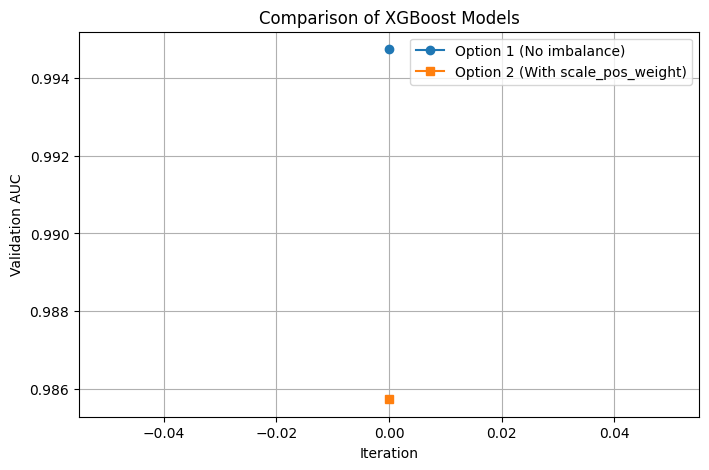

Final Validation AUC (Option1): 0.9947
Final Validation AUC (Option2): 0.9857


In [24]:
from sagemaker.analytics import TrainingJobAnalytics
import matplotlib.pyplot as plt

job_option1 = "sagemaker-xgboost-2025-09-20-18-01-11-206"
job_option2 = "sagemaker-xgboost-2025-09-20-18-04-28-203"

def get_auc_from_analytics(job_name):
    """Fetch validation AUC values using SageMaker Analytics."""
    analytics = TrainingJobAnalytics(
        training_job_name=job_name,
        metric_names=["validation:auc"]
    )
    df = analytics.dataframe()
    if df.empty:
        print(f"⚠️ No AUC metrics found for job: {job_name}")
        return []
    # Sort by timestamp so curve is correct
    df = df.sort_values("timestamp")
    return df["value"].tolist()

# Fetch AUCs
auc_option1 = get_auc_from_analytics(job_option1)
auc_option2 = get_auc_from_analytics(job_option2)

# Plot
plt.figure(figsize=(8,5))
if auc_option1:
    plt.plot(auc_option1, label="Option 1 (No imbalance)", marker="o")
if auc_option2:
    plt.plot(auc_option2, label="Option 2 (With scale_pos_weight)", marker="s")
plt.xlabel("Iteration")
plt.ylabel("Validation AUC")
plt.title("Comparison of XGBoost Models")
plt.legend()
plt.grid(True)
plt.show()

# Print final AUC
if auc_option1:
    print(f"Final Validation AUC (Option1): {auc_option1[-1]:.4f}")
else:
    print("⚠️ No AUC metrics for Option1")

if auc_option2:
    print(f"Final Validation AUC (Option2): {auc_option2[-1]:.4f}")
else:
    print("⚠️ No AUC metrics for Option2")
